In [1]:
import numpy as np
import pandas as pd
import datetime

import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
# Check important features using PCA
from sklearn.decomposition import PCA
from operator import itemgetter

In [2]:
FILE = '../data/globalterrorismdb.csv'
raw_df = pd.read_csv(FILE, index_col='eventid', encoding='ISO-8859-1')

/Users/ninz/.local/share/virtualenvs/cs297-fZk1rqQo/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (4,6,31,33,53,61,62,63,76,79,90,92,94,96,114,115,121) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
pd.set_option('display.max_columns', None)
raw_df.head(5)

,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,region_txt,provstate,city,latitude,longitude,specificity,vicinity,location,summary,crit1,crit2,crit3,doubtterr,alternative,alternative_txt,multiple,success,suicide,attacktype1,attacktype1_txt,attacktype2,attacktype2_txt,attacktype3,attacktype3_txt,targtype1,targtype1_txt,targsubtype1,targsubtype1_txt,corp1,target1,natlty1,natlty1_txt,targtype2,targtype2_txt,targsubtype2,targsubtype2_txt,corp2,target2,natlty2,natlty2_txt,targtype3,targtype3_txt,targsubtype3,targsubtype3_txt,corp3,target3,natlty3,natlty3_txt,gname,gsubname,gname2,gsubname2,gname3,gsubname3,motive,guncertain1,guncertain2,guncertain3,individual,nperps,nperpcap,claimed,claimmode,claimmode_txt,claim2,claimmode2,claimmode2_txt,claim3,claimmode3,claimmode3_txt,compclaim,weaptype1,weaptype1_txt,weapsubtype1,weapsubtype1_txt,weaptype2,weaptype2_txt,weapsubtype2,weapsubtype2_txt,weaptype3,weaptype3_txt,weapsubtype3,weapsubtype3_txt,weaptype4,weaptype4_txt,weapsubtype4,weapsubtype4_txt,weapdetail,nkill,nkillus,nkillter,nwound,nwoundus,nwoundte,property,propextent,propextent_txt,propvalue,propcomment,ishostkid,nhostkid,nhostkidus,nhours,ndays,divert,kidhijcountry,ransom,ransomamt,ransomamtus,ransompaid,ransompaidus,ransomnote,hostkidoutcome,hostkidoutcome_txt,nreleased,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
eventid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
197000000001,1970,7,2,NaN,0,NaN,58,Dominican Republic,2,Central America & Caribbean,NaN,Santo Domingo,18.456792,-69.951164,1.0,0,NaN,NaN,1,1,1,0,NaN,NaN,0,1,0,1,Assassination,NaN,NaN,NaN,NaN,14,Private Citizens & Property,68.0,Named Civilian,NaN,Julio Guzman,58.0,Dominican Republic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MANO-D,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PGIS,0,0,0,0,NaN
197000000002,1970,0,0,NaN,0,NaN,130,Mexico,1,North America,NaN,Mexico city,19.432608,-99.133207,1.0,0,NaN,NaN,1,1,1,0,NaN,NaN,0,1,0,6,Hostage Taking (Kidnapping),NaN,NaN,NaN,NaN,7,Government (Diplomatic),45.0,"Diplomatic Personnel (outside of embassy, cons...",Belgian Ambassador Daughter,"Nadine Chaval, daughter",21.0,Belgium,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23rd of September Communist League,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN,1.0,1.0,0.0,NaN,NaN,NaN,Mexico,1.0,800000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PGIS,0,1,1,1,NaN
197001000001,1970,1,0,NaN,0,NaN,160,Philippines,5,Southeast Asia,Tarlac,Unknown,15.478598,120.599741,4.0,0,NaN,NaN,1,1,1,0,NaN,NaN,0,1,0,1,Assassination,NaN,NaN,NaN,NaN,10,Journalists & Media,54.0,Radio Journalist/Staff/Facility,Voice of America,Employee,217.0,United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
197001000002,1970,1,0,NaN,0,NaN,78,Greece,8,Western Europe,Attica,Athens,37.983773,23.728157,1.0,0,NaN,NaN,1,1,1,0,NaN,NaN,0,1,0,3,Bombing/Explosion,NaN,NaN,NaN,NaN,7,Government (Diplomatic),46.0,Embassy/Consulate,NaN,U.S. Embassy,217.0,United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,Explosives/Bombs/Dyn

#### Examine the data

Eyeballing the data, here are some of the less obvious but useful columns

- success
- attacktypes
- targettypes
- targetsubtypes
- nationality of target ?
- weapontypes
- related?


**NOTE**
Mention in the report that data such as kills are removed since the objective is to just relate terrorist attacks to several factors. Some terrorist attacks that target individuals only exist but it might be too little to consider.

In [4]:
# Get mappings for numeric columns with text equivalent
def extract_mapping(df, numeric, text):
    _tmp = raw_df[[numeric, text]]
    _tmp = _tmp.drop_duplicates()
    return {r[numeric]: r[text] for i, r in _tmp.iterrows()}

country_mappings = extract_mapping(raw_df, 'country', 'country_txt')
region_mappings = extract_mapping(raw_df, 'region', 'region_txt')
attack_type_mappings = extract_mapping(raw_df, 'attacktype1', 'attacktype1_txt')
target_type_mappings = extract_mapping(raw_df, 'targtype1', 'targtype1_txt')
target_sub_type_mappings = extract_mapping(raw_df, 'targsubtype1', 'targsubtype1_txt')
nationality_target_mappings = extract_mapping(raw_df, 'natlty1', 'natlty1_txt')
weapon_type_mappings = extract_mapping(raw_df, 'weaptype1', 'weaptype1_txt')

In [5]:
minified_cols = ['iyear', 'imonth', 'iday', 'extended', 'resolution', 
                'country', 'region', 'success', 'attacktype1', 'targtype1',
               'natlty1', 'weaptype1']
minified_df = raw_df[minified_cols]

minified_df.head(2)

,iyear,imonth,iday,extended,resolution,country,region,success,attacktype1,targtype1,natlty1,weaptype1
eventid,,,,,,,,,,,,
197000000001,1970,7,2,0,NaN,58,2,1,1,14,58.0,13
197000000002,1970,0,0,0,NaN,130,1,1,6,7,21.0,13


In [6]:
country_mappings

{58: 'Dominican Republic',
 130: 'Mexico',
 160: 'Philippines',
 78: 'Greece',
 101: 'Japan',
 217: 'United States',
 218: 'Uruguay',
 98: 'Italy',
 499: 'East Germany (GDR)',
 65: 'Ethiopia',
 83: 'Guatemala',
 222: 'Venezuela',
 362: 'West Germany (FRG)',
 199: 'Switzerland',
 102: 'Jordan',
 185: 'Spain',
 30: 'Brazil',
 60: 'Egypt',
 11: 'Argentina',
 110: 'Lebanon',
 96: 'Ireland',
 209: 'Turkey',
 158: 'Paraguay',
 94: 'Iran',
 603: 'United Kingdom',
 45: 'Colombia',
 26: 'Bolivia',
 145: 'Nicaragua',
 142: 'Netherlands',
 21: 'Belgium',
 97: 'Israel',
 38: 'Canada',
 14: 'Australia',
 153: 'Pakistan',
 230: 'Zambia',
 198: 'Sweden',
 49: 'Costa Rica',
 406: 'South Yemen',
 36: 'Cambodia',
 201: 'Taiwan',
 156: 'Panama',
 106: 'Kuwait',
 155: 'West Bank and Gaza Strip',
 15: 'Austria',
 236: 'Czechoslovakia',
 92: 'India',
 69: 'France',
 428: 'South Vietnam',
 6: 'Algeria',
 61: 'El Salvador',
 205: 'Thailand',
 87: 'Haiti',
 195: 'Sudan',
 136: 'Morocco',
 53: 'Cyprus',
 138: '

In [7]:
grouped_by_year_region = minified_df.groupby(['iyear', 'region']).size().to_frame('number_of_attacks').reset_index()
grouped_by_year = minified_df.groupby(['iyear', 'country']).size().to_frame('number_of_attacks').reset_index()
grouped_by_month = minified_df.groupby(['iyear', 'imonth', 'country']).size().to_frame('number_of_attacks').reset_index()

In [8]:
# mean number of attack is 46
def label_attack(r):
    if r['number_of_attacks'] < 20:
        return 'few'
    elif r['number_of_attacks'] < 40:
        return 'minimal'
    elif r['number_of_attacks'] < 60:
        return 'average'
    else:
        return 'many'

grouped_by_month['attack_category'] = grouped_by_month.apply (label_attack, axis=1)
grouped_by_year['attack_category'] = grouped_by_year.apply (label_attack, axis=1)

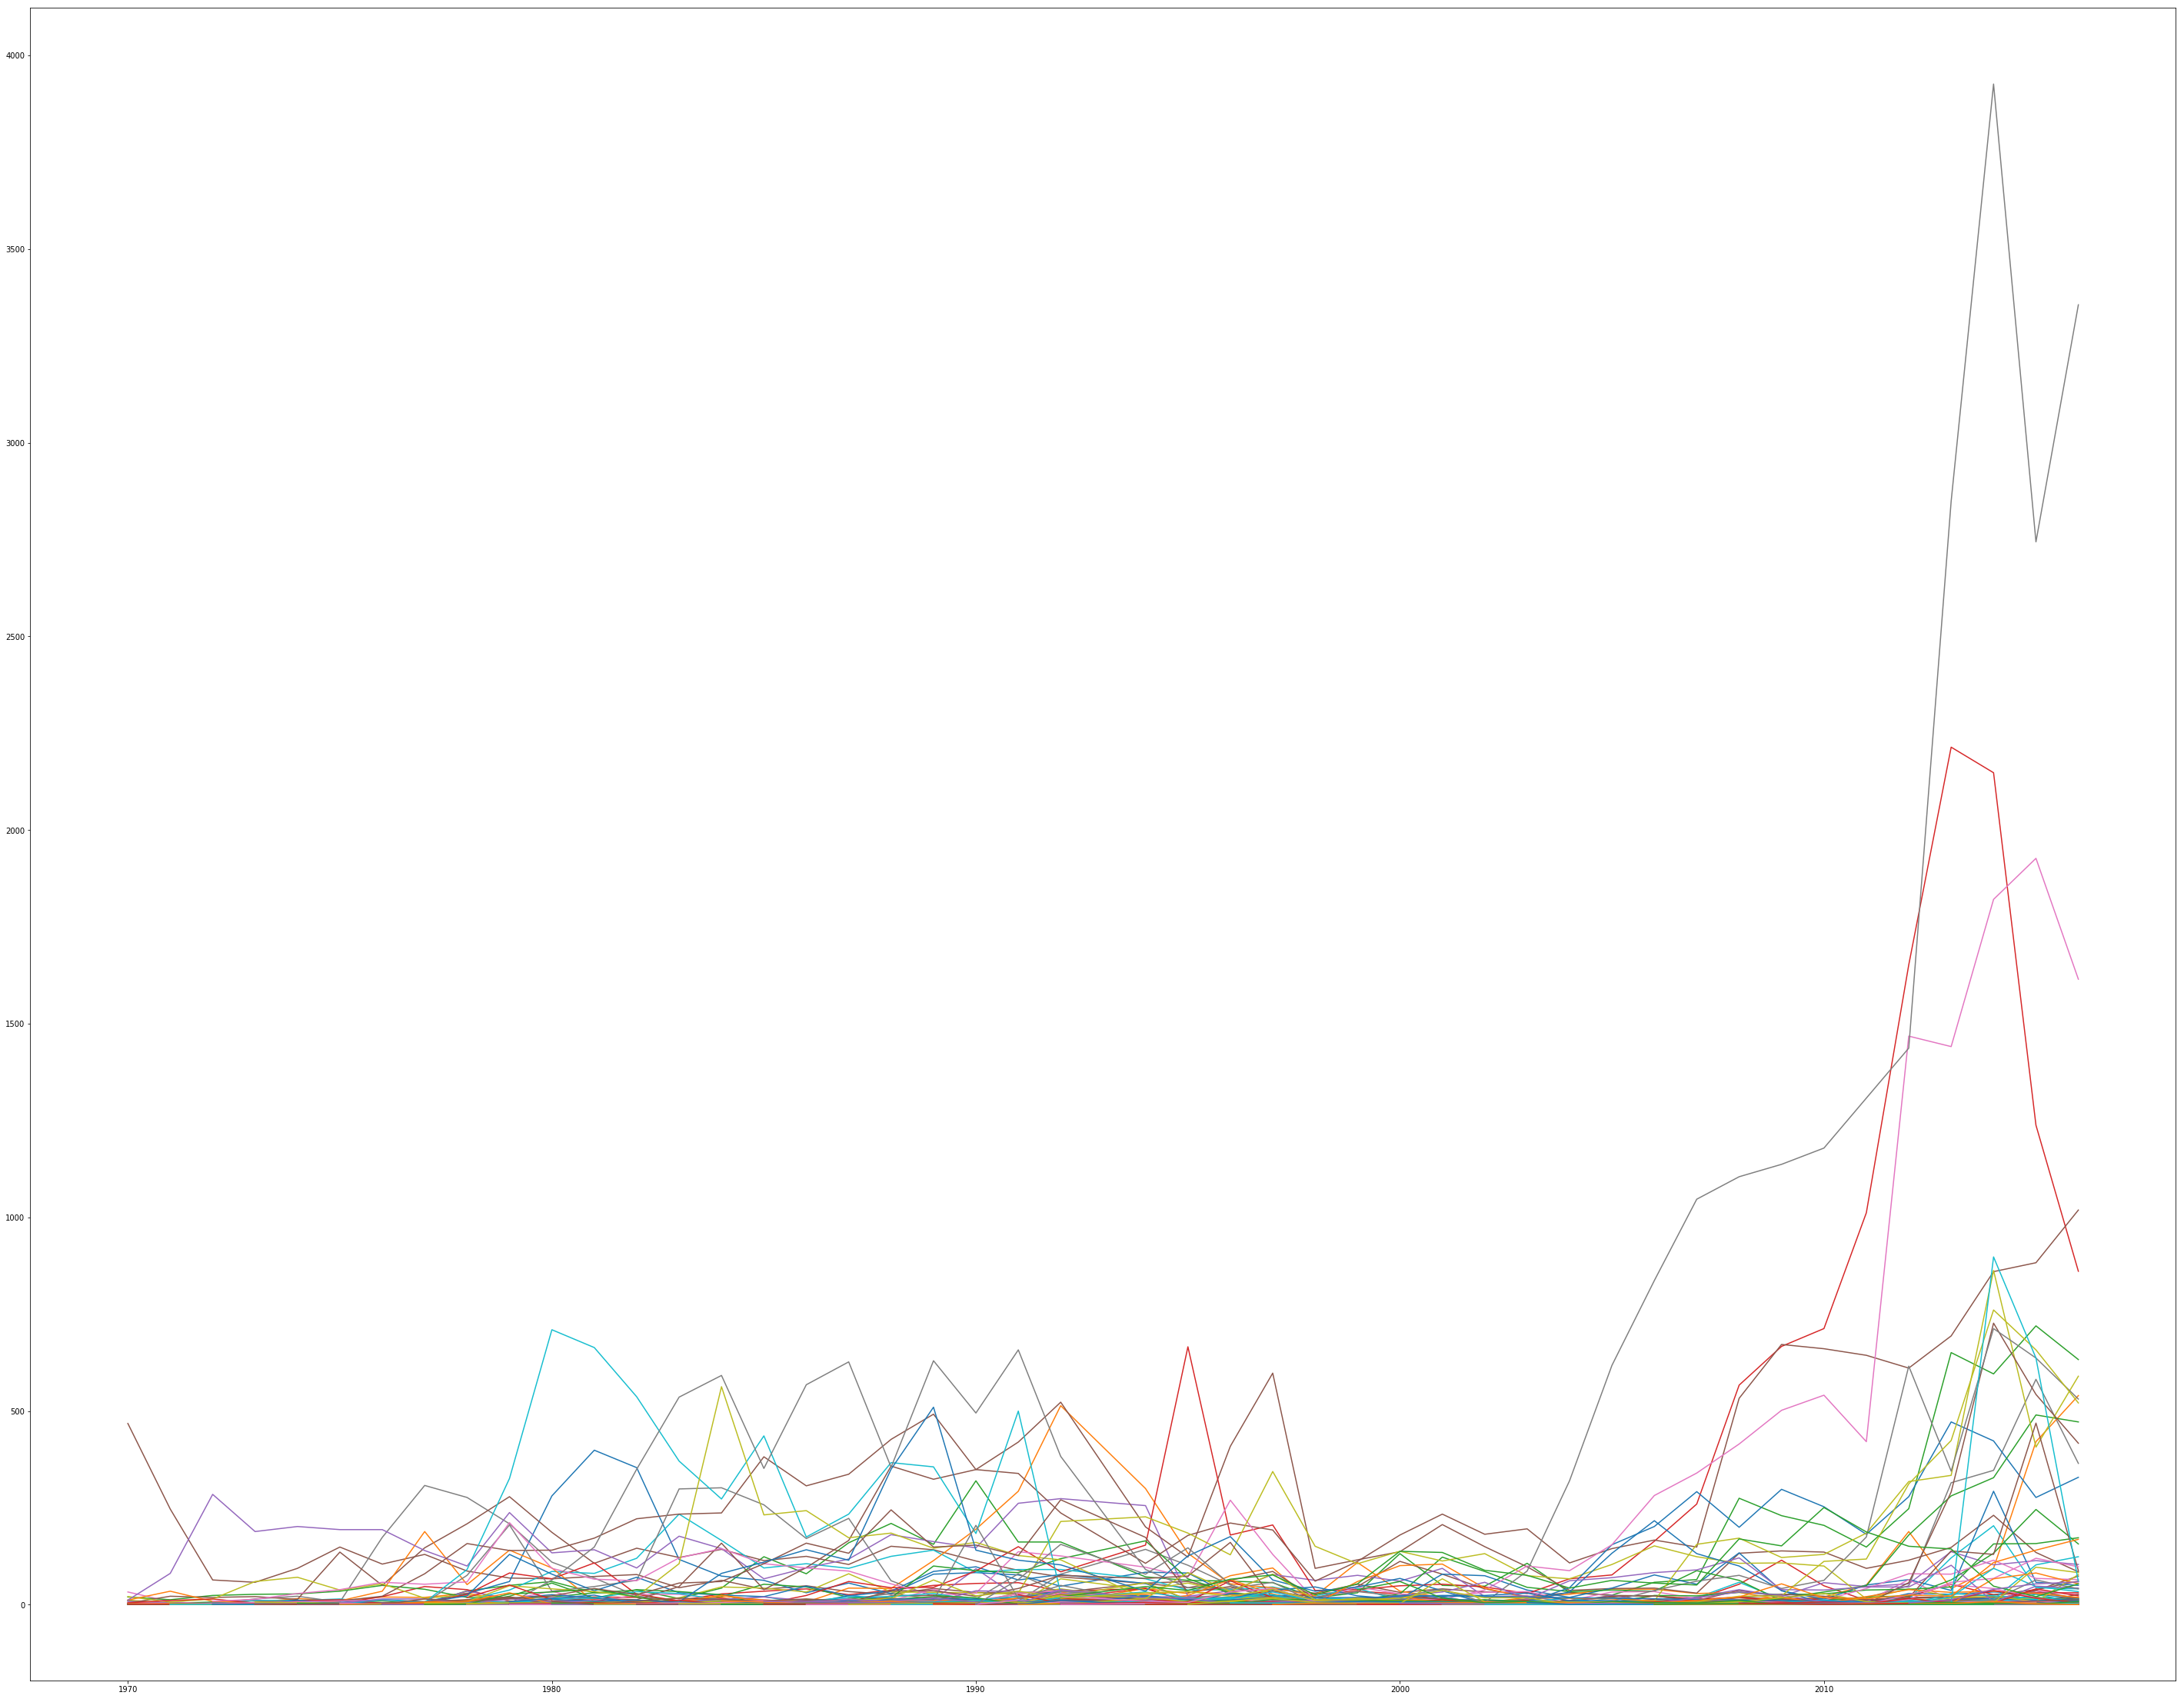

In [9]:
plt.figure(figsize=(50,40))
for _c in country_mappings:
    x = grouped_by_year[grouped_by_year.country == _c].iyear
    y = grouped_by_year[grouped_by_year.country == _c].number_of_attacks
    plt.plot(x,y)
#     print(grouped_by_year[grouped_by_year.country == _c].iyear)

plt.show()

In [10]:
grouped_by_year_region.head(2)

,iyear,region,number_of_attacks
0,1970,1,472
1,1970,2,7


In [11]:
# Econ data merged
FILE = '../data/economic-terrorism-data.csv'
eco_df = pd.read_csv(FILE)

In [12]:
minified_eco_cols = ['iyear', 'imonth', 'iday', 'extended', 'country', 'region', 'success', 
                     'attacktype1', 'targtype1', 'natlty1', 'weaptype1', 'gdp', 'inf', 'pop']
eco_df = eco_df[minified_eco_cols]

In [13]:
eco_df.head()

,iyear,imonth,iday,extended,country,region,success,attacktype1,targtype1,natlty1,weaptype1,gdp,inf,pop
0,1970,7,2,0,58,2,1,1,14,58.0,13,1.485400e+09,2.104839,4503114.0
1,1970,0,0,0,130,1,1,6,7,21.0,13,3.554171e+10,2.632475,52029861.0
2,1970,1,0,0,160,5,1,1,10,217.0,13,6.687205e+09,15.155504,35804729.0
3,1970,1,0,0,78,8,1,3,7,217.0,6,1.313986e+10,7.990874,8792806.0
4,1970,1,0,0,101,4,1,7,7,217.0,8,2.115142e+11,24.093187,104345000.0


In [14]:

eco_year_region = eco_df.groupby(['iyear', 'region'])['gdp', 'inf', 'pop'].agg(
    {'gdp': 'mean', 'inf': 'mean', 'pop': 'mean'}).reset_index()


eco_year = eco_df.groupby(['iyear', 'country'])['gdp', 'inf', 'pop'].agg(
    {'gdp': 'mean', 'inf': 'mean', 'pop': 'mean'}).reset_index()



In [15]:
eco_year_region['number_of_attacks'] = grouped_by_year_region['number_of_attacks']
eco_year['number_of_attacks'] = grouped_by_year['number_of_attacks']

In [16]:
eco_year_region.head(10)

,iyear,region,gdp,inf,pop,number_of_attacks
0,1970,1,1.067289e+12,2.229519,2.036251e+08,472.0
1,1970,2,1.512400e+09,3.807591,4.841642e+06,7.0
2,1970,3,1.533112e+10,6.089432,1.841784e+07,65.0
3,1970,4,2.115142e+11,24.093187,1.043450e+08,2.0
4,1970,5,6.687205e+09,15.155504,3.580473e+07,10.0
5,1970,6,1.002709e+10,4.306905,5.809076e+07,1.0
6,1970,8,1.310959e+11,4.863308,5.249436e+07,49.0
7,1970,9,2.150218e+11,0.000000,7.816929e+07,12.0
8,1970,10,7.528566e+09,3.704788,1.558153e+07,29.0
9,1970,11,0.000000e+00,0.000000,2.841508e+07,3.0


In [17]:
eco_year_region['attack_category'] = eco_year_region.apply (label_attack, axis=1)
eco_year['attack_category'] = eco_year.apply (label_attack, axis=1)

In [18]:
eco_year_region.head(5)

,iyear,region,gdp,inf,pop,number_of_attacks,attack_category
0,1970,1,1.067289e+12,2.229519,2.036251e+08,472.0,many
1,1970,2,1.512400e+09,3.807591,4.841642e+06,7.0,few
2,1970,3,1.533112e+10,6.089432,1.841784e+07,65.0,many
3,1970,4,2.115142e+11,24.093187,1.043450e+08,2.0,few
4,1970,5,6.687205e+09,15.155504,3.580473e+07,10.0,few


In [66]:
def perform_classifier_with_PCA(X, y, n_comp, n_estimators):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)

    clf = RandomForestClassifier(random_state=0, n_estimators=n_estimators).fit(X_train, y_train)
    
    pca = PCA(n_components=n_comp).fit(X)
    loadings = pca.components_
    var = pca.explained_variance_ratio_
    headers = X.columns
    
    
    fig, axes = plt.subplots(figsize=(15, 15))

    for i, ax in enumerate(var):
        plt.subplot(2, 2, i+1)
        plt.title('PCA{} Factor Loading ({})'.format(i+1, round(var[i], 2)))
        data = zip(headers, loadings[i], abs(loadings[i]))
        headers_s, loadings_actual, loadings_abs = zip(*sorted(data, reverse=True, key=itemgetter(2)))
        plt.bar(range(len(headers)), loadings_actual)
        plt.xticks(range(len(headers)), headers_s, rotation=45)

    plt.tight_layout()
    plt.show()
    
    score = clf.score(X_test, y_test)
    print('Score on the test dataset', score)
    
def get_region_gdp(_df, comparison):
    for i, r in region_mappings.items():
        fig, ax = plt.subplots(figsize=(5, 5))
        plt.title('{}'.format(r))

        _ax = ax.twinx()

        x = _df[_df.region == i].iyear
        y = _df[_df.region == i].number_of_attacks
        ax.plot(x,y, 'g-')

        x = _df[_df.region == i].iyear
        y = _df[_df.region == i][comparison]
        _ax.plot(x,y, 'b-')

        ax.set_xlabel('Year data')
        ax.set_ylabel('Number of attacks', color='g')
        _ax.set_ylabel(comparison, color='b')

    plt.tight_layout()
    plt.show()
    
def get_per_country_gov(_df, country, comparison):
    
    fig, ax = plt.subplots(figsize=(5, 5))
    plt.title('{}'.format(country_mappings[country]))

    _ax = ax.twinx()

    x = _df[_df.country == country].iyear
    y = _df[_df.country == country].number_of_attacks
    ax.plot(x,y, 'g-')

    x = _df[_df.country == country].iyear
    y = _df[_df.country == country][comparison]
    _ax.plot(x,y, 'b-')

    ax.set_xlabel('Year data')
    ax.set_ylabel('Number of attacks', color='g')
    _ax.set_ylabel(comparison, color='b')

    plt.tight_layout()
    plt.show()

### Performing some analysis on the data

#### Per region dataset

- Get X features and y target
- Split the dataset for verification
- Apply some classifiers -- RandomForestClassifier (tried other classifier before, this one has the highest)
- Measure score on test set

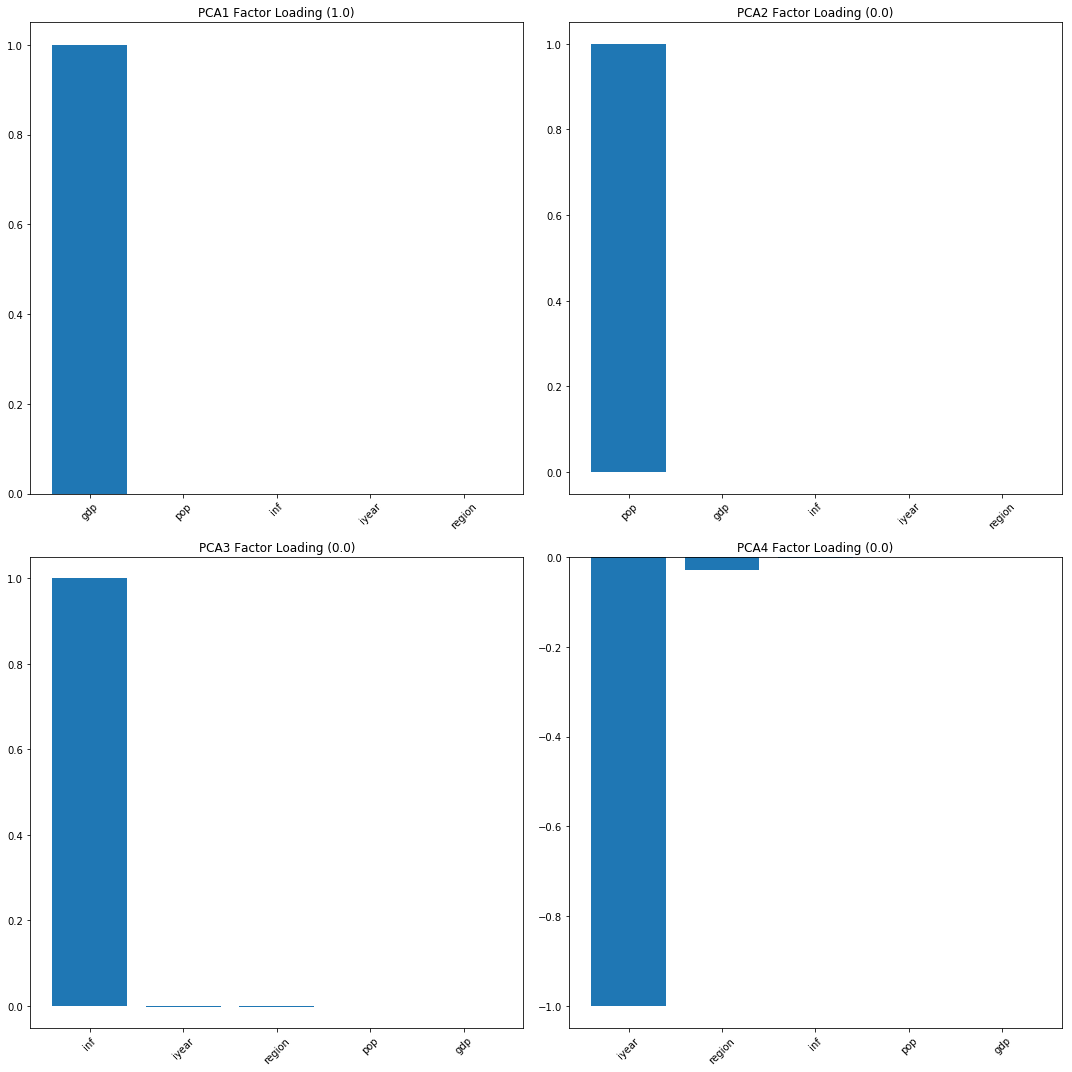

Score on the test dataset 0.8238993710691824


In [58]:
X = eco_year_region[['iyear', 'region', 'gdp', 'inf', 'pop']]
y = eco_year_region['attack_category']

# Using all feature from economic data
perform_classifier_with_PCA(X, y, 4, 20)

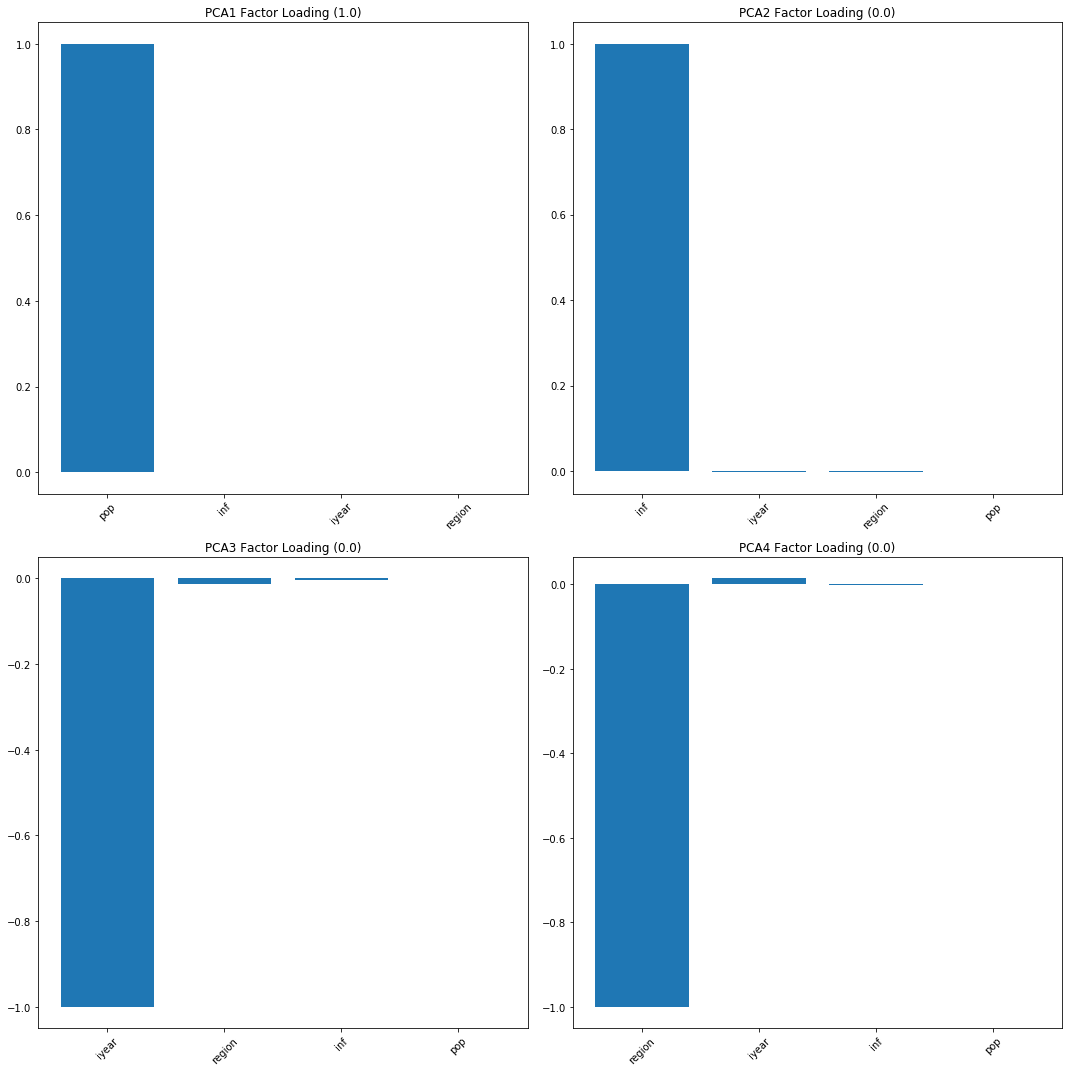

Score on the test dataset 0.8176100628930818


In [59]:
X = eco_year_region[['iyear', 'region', 'inf', 'pop']]
y = eco_year_region['attack_category']

# Removing the gdp feature
# n_estimator @ 30 gives the highest prediction result
perform_classifier_with_PCA(X, y, 4, 30)

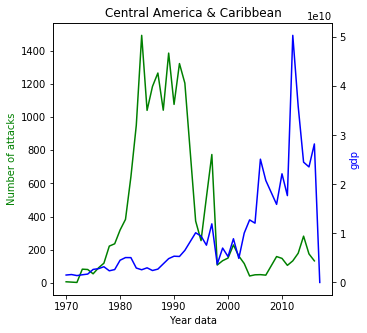

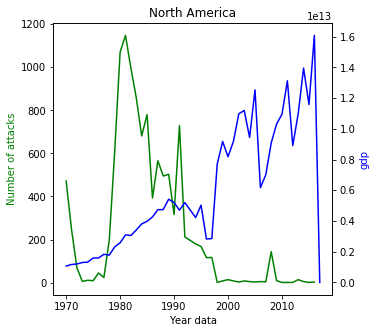

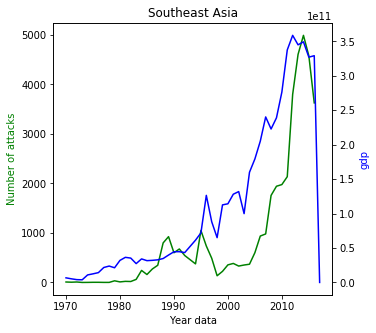

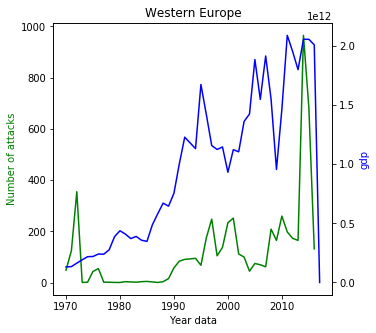

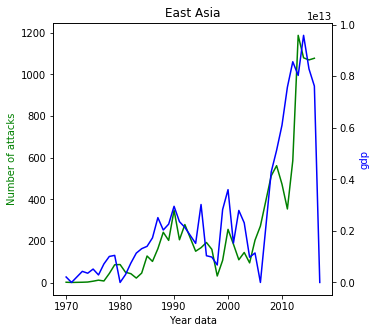

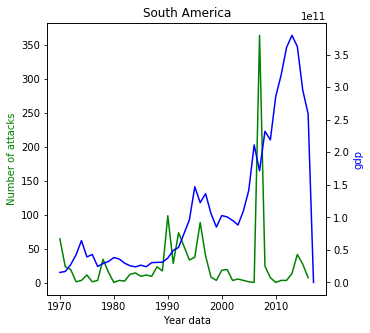

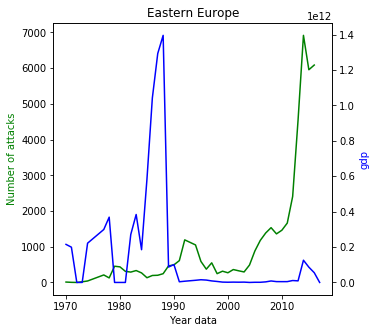

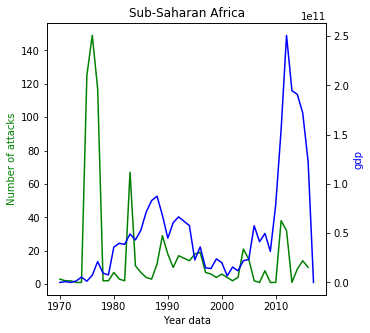

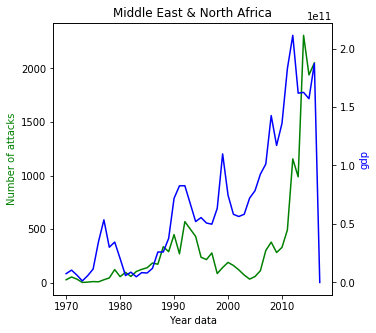

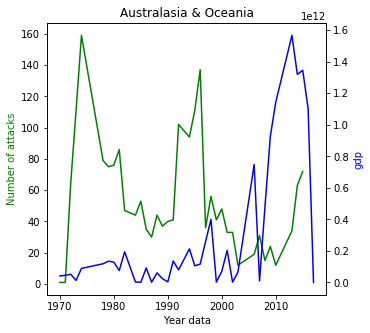

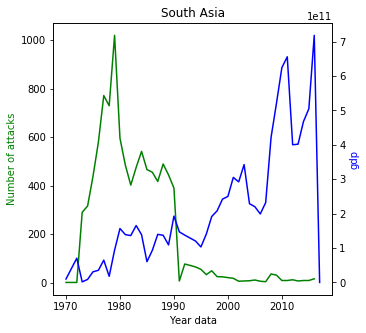

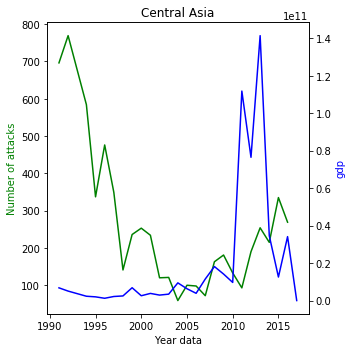

In [60]:
get_region_gdp(eco_year_region, 'gdp')

Proportional GDP vs Terrorism trends

- Southeast Asia
- East Asia
- South America
- Middle East and North Africa
- Western Eu?

Most of these regions are 3rd world countries.


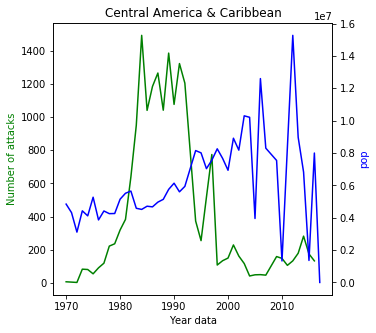

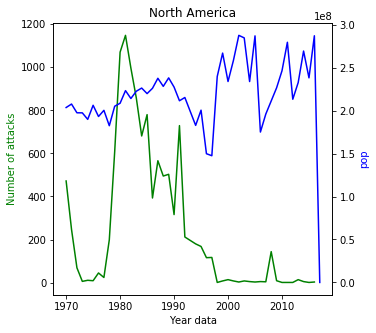

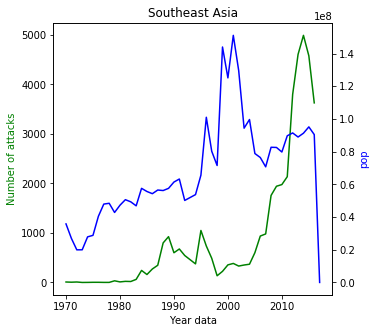

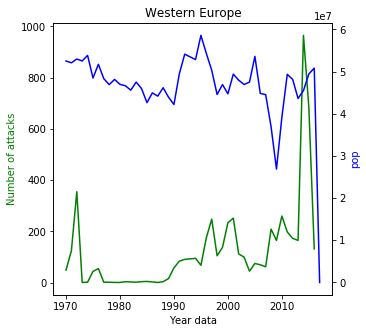

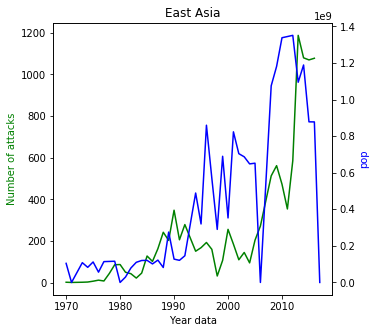

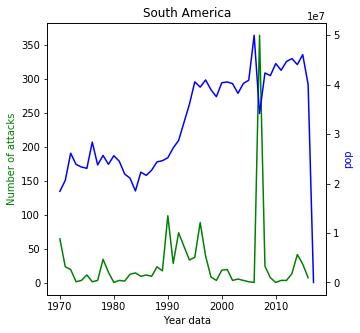

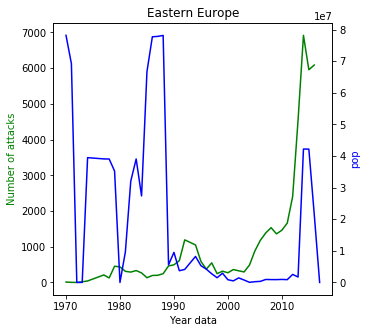

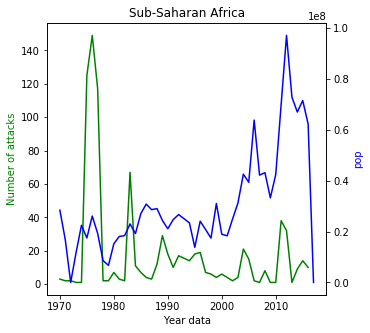

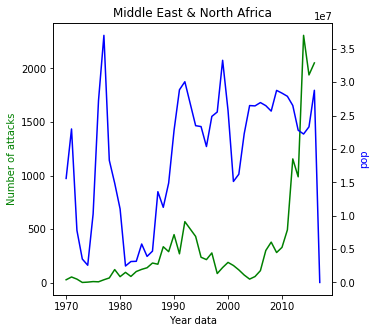

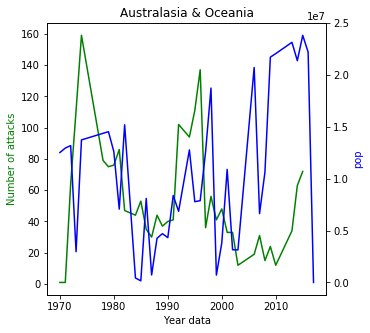

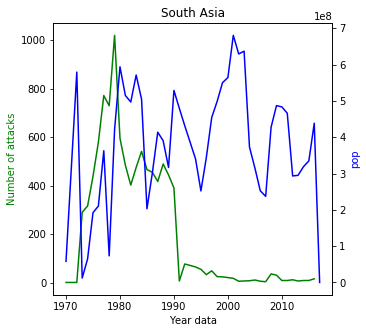

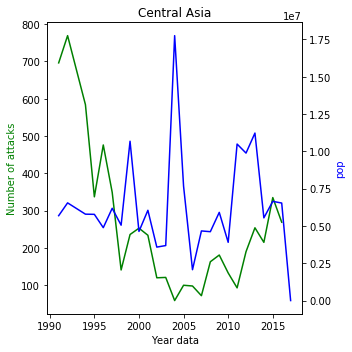

In [61]:
get_region_gdp(eco_year_region, 'pop')

#### GDP as the main driver in the per region basis

When GDP is included in the feature set, the prediction result is at 82% accuracy on the test set. This makes sense as the economic situation of a country is directly affected on terrorism attacks.

Population is also a good metric in predicting terrorism activity.

The score of `0.8176100628930818` is not that far from `0.8238993710691824` (with all the data).


#### Per country dataset

- Get X features and y target
- Split the dataset for verification
- Apply some classifiers -- RandomForestClassifier (tried other classifier before, this one has the highest)
- Measure score on test set

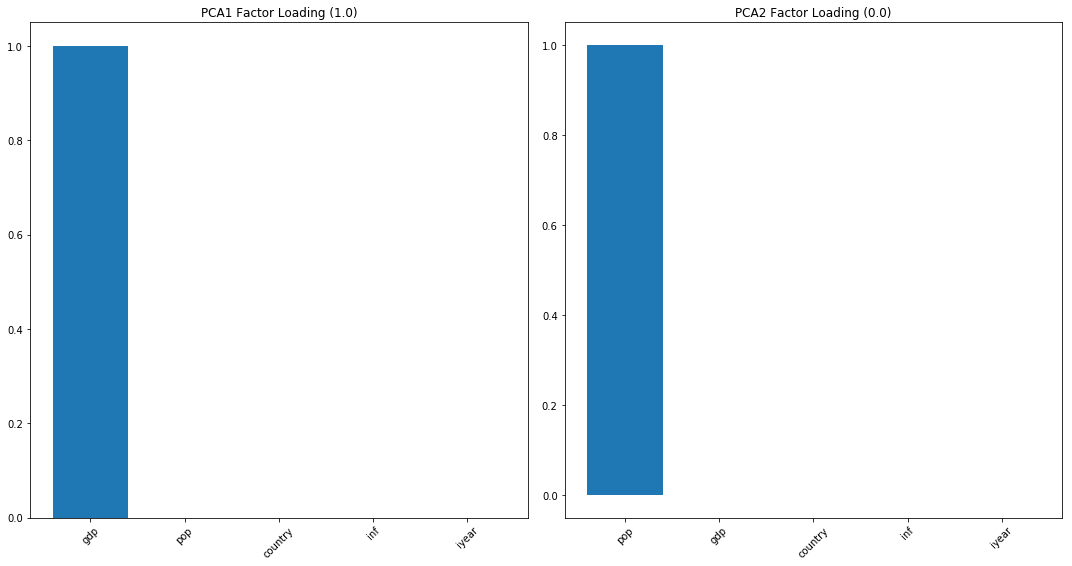

Score on the test dataset 0.6908768821966342


In [62]:
X = eco_year[['iyear', 'country', 'gdp', 'inf', 'pop']]
y = eco_year['attack_category']

# Removing the gdp feature
# n_estimator @ 30 gives the highest prediction result
perform_classifier_with_PCA(X, y, 2, 30)

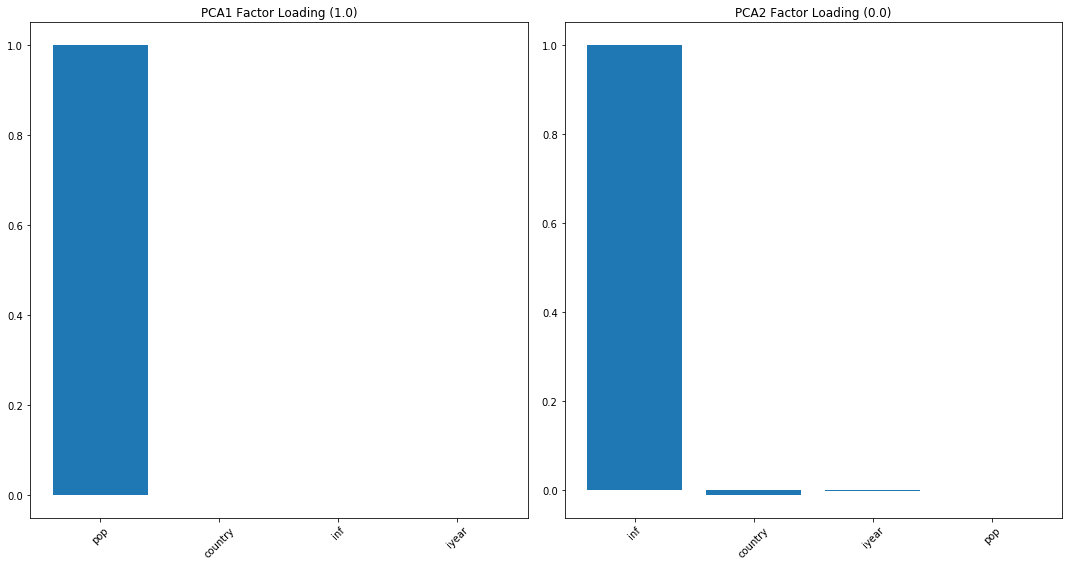

Score on the test dataset 0.6891054030115146


In [63]:
X = eco_year[['iyear', 'country', 'inf', 'pop']]
y = eco_year['attack_category']

# Removing the gdp feature
# n_estimator @ 30 gives the highest prediction result
perform_classifier_with_PCA(X, y, 2, 30)

#### GDP as the main driver in the per country basis

The prediction score of `0.6908768821966342` is better than `0.6891054030115146`

In the per region and per country data, it can be seen that BOTH GDP and Population has the same relation score in terms of terrorism.

In [64]:
# Get the top 5 countries in terms of GDP
s = eco_year.groupby(['country'])['gdp', 'inf', 'pop', 'number_of_attacks'].agg(
    {'gdp': 'mean', 'inf': 'mean', 'pop': 'mean', 'number_of_attacks': 'sum'}).reset_index()
s.sort_values(by=['gdp'], ascending=False, inplace=True)
top5_gdp = s.country[0: 5]
s.sort_values(by=['number_of_attacks'], ascending=False, inplace=True)
top5_terrorism = s.country[0: 10]

--Top GDP--


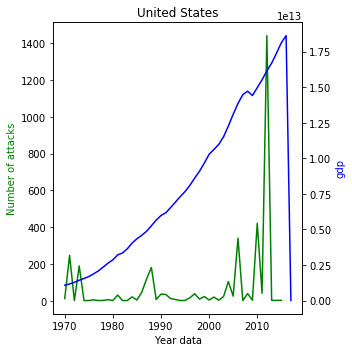

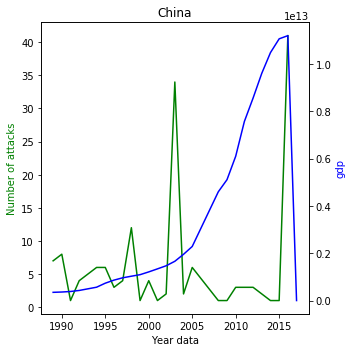

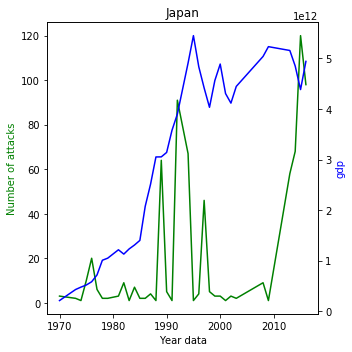

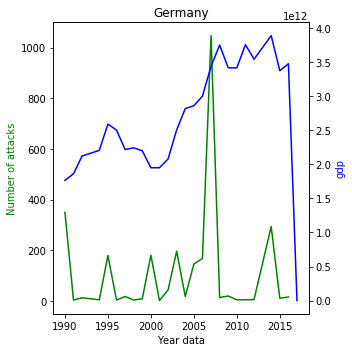

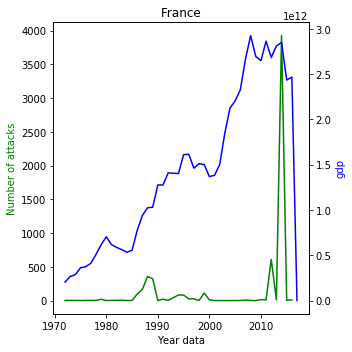

--Top Terrorism--


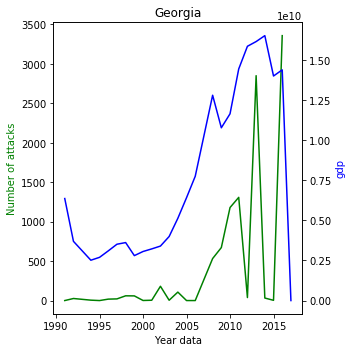

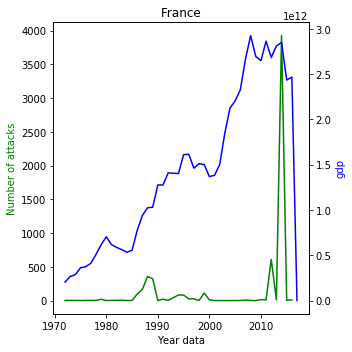

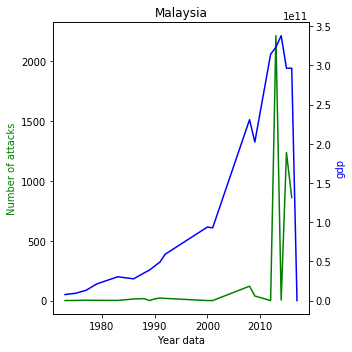

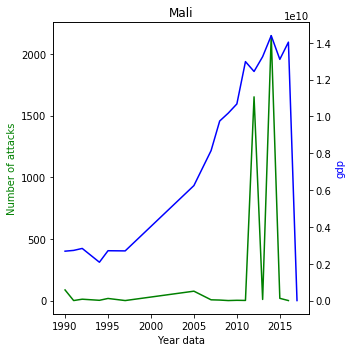

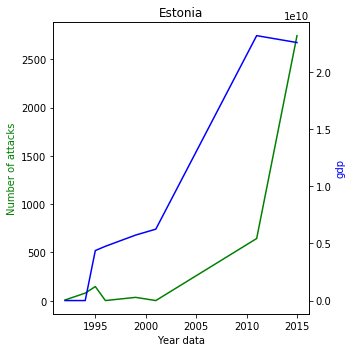

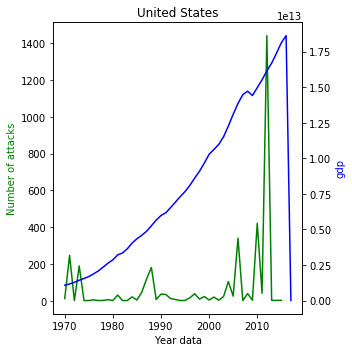

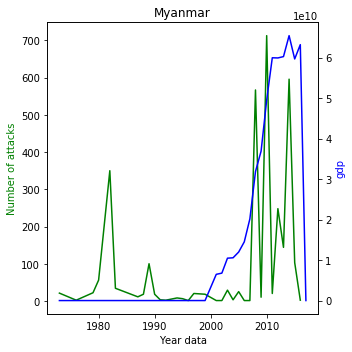

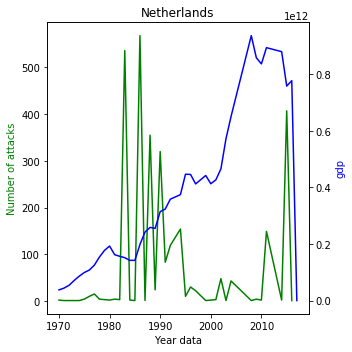

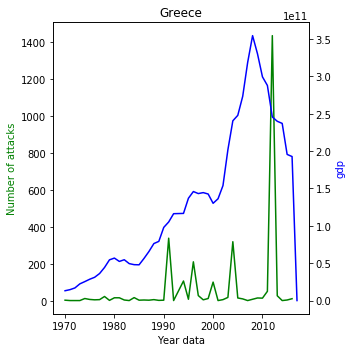

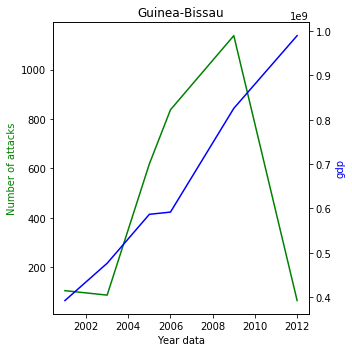

In [69]:
print('--Top GDP--')
for t in top5_gdp:
    get_per_country_gov(eco_year, t, 'gdp')
    
print('--Top Terrorism--')
for t in top5_terrorism:
    get_per_country_gov(eco_year, t, 'gdp')
    

Looking at terrorism data per region in the context of GDP might be a better option. 

### Govt data

In [ ]:
FILE = '../data/cleaned_gov2.csv'
gov_df = pd.read_csv(FILE, index_col='idx')

In [ ]:
gov_df.head(2)

In [ ]:
FILE = '../data/cleaned_gov3.csv'
gov2_df = pd.read_csv(FILE, index_col='idx')

In [ ]:
gov2_df.head()

In [ ]:
cols = [
    'iyear', 'country', 'number_of_attacks', 'attack_category', 'military', 'numopp', 'numadmin',
    'legelec', 'exelec', 'numgov', 'is_presidential', 'is_parliamentary', 'is_essembly_elected', 
    'is_left_oriented', 'is_right_oriented', 'is_center_oriented', 'change_ruling_party'
]

gov_terror = gov2_df[cols]

In [ ]:
gov_terror.groupby('is_parliamentary').size()
# Just convert it to 0 since its just 48

In [ ]:
gov_terror.loc[gov_terror.military == -999.0, 'military'] = 0.0
gov_terror.loc[gov_terror.legelec == -999.0, 'legelec'] = 0.0
gov_terror.loc[gov_terror.exelec == -999.0, 'exelec'] = 0.0

In [ ]:
gov_terror = gov_terror.fillna(gov_terror.mean())

In [ ]:
X = gov_terror[['iyear', 'country', 'military', 'numopp', 'numadmin', 'legelec', 'exelec', 'is_presidential', 'is_parliamentary', 'is_essembly_elected', 
    'is_left_oriented', 'is_right_oriented', 'is_center_oriented', 'change_ruling_party']]
y = gov_terror['attack_category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)


In [ ]:
# NOTE: Played with the n_estimators variable, the best value is 20
clf = RandomForestClassifier(random_state=0, n_estimators=20).fit(X_train, y_train)

In [ ]:
score = clf.score(X_test, y_test)
print(score)

In [ ]:
# Do PCA on the X
pca = PCA(n_components=4).fit(X)
loadings = pca.components_
var = pca.explained_variance_ratio_
headers = X.columns

In [ ]:
fig, axes = plt.subplots(figsize=(15, 15))

for i, ax in enumerate(var):
    plt.subplot(2, 2, i+1)
    plt.title('PCA{} Factor Loading ({})'.format(i+1, round(var[i], 2)))
    data = zip(headers, loadings[i], abs(loadings[i]))
    headers_s, loadings_actual, loadings_abs = zip(*sorted(data, reverse=True, key=itemgetter(2)))
    plt.bar(range(len(headers)), loadings_actual)
    plt.xticks(range(len(headers)), headers_s, rotation=45)
    
plt.tight_layout()
plt.show()

### The number of government seats might be a big contributing factor??? LOL